In [80]:
from omegaconf import OmegaConf
config_path = "logs/2021-11-12T00-59-38_wikiart_landscape_realism_edge_transformer/configs/2021-11-12T00-59-38-project.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 4
    num_workers: 8
    train:
      params:
        img_list_file: datasets/wikiart_train.txt
        size: 256
      target: taming.data.wikiart.WikiartEdgesTrain
    validation:
      params:
        img_list_file: datasets/wikiart_test.txt
        size: 256
      target: taming.data.wikiart.WikiartEdgesTest
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ckpt_path: logs/2021-11-11T22-39-00_wikiart_landscape_realism_edge_vqgan/checkpoints/last.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 1
          num_res_blocks: 2
          out_ch: 1
          resolution: 256
          z_channels: 256
        embed_dim: 256
        lossconfig:
          target: taming.modules.losses.DummyL

In [81]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-11-11T16-36-49_wikiart_portrait_realism_vqgan/checkpoints/last.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-11-11T22-39-00_wikiart_landscape_realism_edge_vqgan/checkpoints/last.ckpt


In [82]:
import torch
ckpt_path = "logs/2021-11-12T00-59-38_wikiart_landscape_realism_edge_transformer/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

In [83]:
model.cuda().eval()
torch.set_grad_enabled(False)

In [84]:
from PIL import Image
from skimage.color import rgb2gray
import numpy as np

edge_path = "datasets/sketches/7.png"
edge = Image.open(edge_path)
edge = np.array(edge)
# edge = np.eye(255)[edge]
edge = rgb2gray(edge)[:,:,None][:,:,[0]]
edge = torch.tensor(edge.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
print(edge.shape)

torch.Size([1, 1, 480, 680])


/tmp/ipykernel_2865/2517160063.py:9: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  edge = rgb2gray(edge)[:,:,None][:,:,[0]]


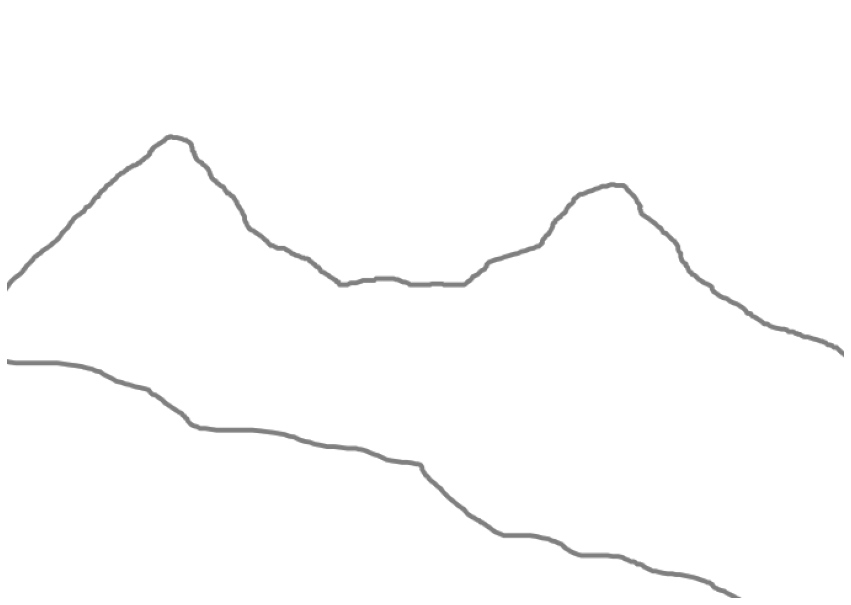

In [20]:
import cv2
import matplotlib.pyplot as plt

def show_edge(e):
  e = e.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
  e = e[...,0,:]
  e = ((e+1.0)*127.5).clip(0,255).astype(np.uint8)
  plt.figure(figsize=(15,15))
  plt.imshow(e, cmap = "gray", vmin=0, vmax=255)
  plt.axis('off')
  # print(e)
  # display(e)

show_edge(edge)

In [15]:
c_code, c_indices = model.encode_to_c(edge)
print("c_code", c_code.shape, c_code.dtype)
print("c_indices", c_indices.shape, c_indices.dtype)
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[1]
edge_rec = model.cond_stage_model.decode(c_code)
# show_edge(torch.softmax(edge_rec, dim=1))

c_code torch.Size([1, 256, 30, 42]) torch.float32
c_indices torch.Size([1, 1260]) torch.int64


z_indices shape torch.Size([1, 1260])
x_sample shape torch.Size([1, 3, 480, 672])


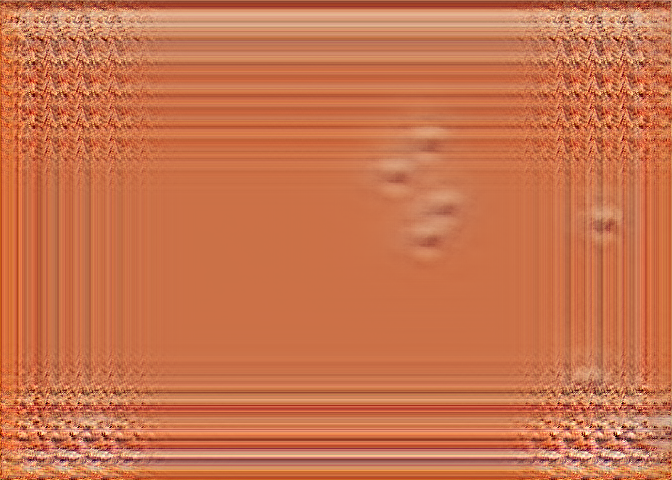

In [16]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices_shape = c_indices.shape
z_code_shape = c_code.shape
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
print("z_indices shape", z_indices.shape)
x_sample = model.decode_to_img(z_indices, z_code_shape)
print("x_sample shape", x_sample.shape)
show_image(x_sample)

codebook size 256
base shape torch.Size([1, 3, 480, 672])


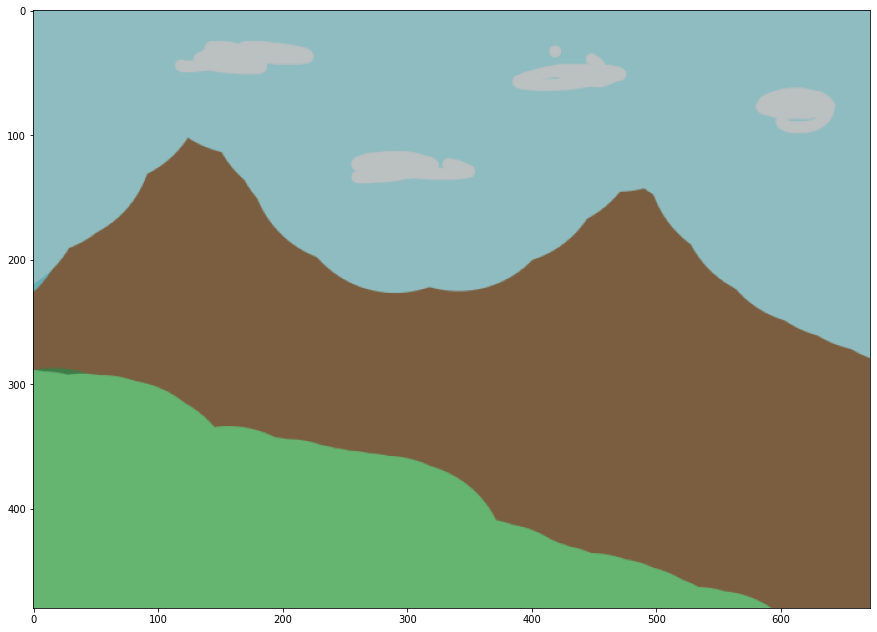

In [94]:
codebook_size = config.model.params.first_stage_config.params.embed_dim
print("codebook size", codebook_size)
z_indices_shape = c_indices.shape
z_code_shape = c_code.shape

base_path = "datasets/sketches/8.png"
x_sample = Image.open(base_path).convert('RGB').resize((672, 480))
x_sample = np.array(x_sample)
x_sample = (x_sample-125.5)/255.0
x_sample = torch.tensor(x_sample.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
print("base shape", x_sample.shape)

_, z_indices = model.encode_to_z(x_sample)

show_edge(x_sample)

Time: 57.98752188682556 seconds
Step: (29,41) | Local: (15,15) | Crop: (14:30,26:42)


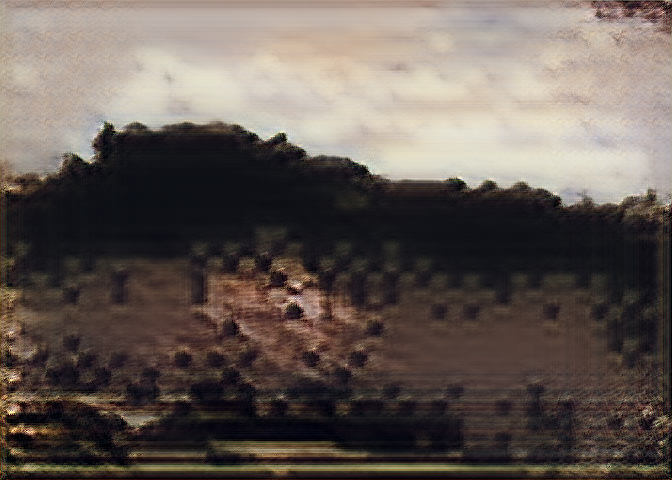

In [17]:
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature =1.0
top_k = 100
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0):
  if i <= 8:
    local_i = i
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  else:
    local_i = 8
  for j in range(0,z_code_shape[3]-0):
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8

    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)
    patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1])
    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]

    logits = logits/temperature

    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      show_image(x_sample)

In [86]:
from skimage.feature import canny
from PIL import Image
from skimage.color import rgb2gray
import numpy as np
from tqdm import tqdm

def get_edge(image):
    edge = canny(rgb2gray(image), 1.75, 0.15, 0.75)
    edge = 1.0 - edge.astype(np.float32)
    return edge

def generate_art(path, image_i):
    img = Image.open(path).resize((256,256))
    img = np.array(img)
    edge = get_edge(img)

    edge = edge[:,:,None][:,:,[0]]
    edge = torch.tensor(edge.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)

    c_code, c_indices = model.encode_to_c(edge)
    assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[1]

    codebook_size = config.model.params.first_stage_config.params.embed_dim
    z_indices_shape = c_indices.shape
    z_code_shape = c_code.shape
    z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
    x_sample = model.decode_to_img(z_indices, z_code_shape)
    
    idx = z_indices
    idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

    cidx = c_indices
    cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

    temperature =1.0
    top_k = 100
    update_every = 50

    start_t = time.time()
    for i in range(0, z_code_shape[2]-0):
      if i <= 8:
        local_i = i
      elif z_code_shape[2]-i < 8:
        local_i = 16-(z_code_shape[2]-i)
      else:
        local_i = 8
      for j in range(0,z_code_shape[3]-0):
        if j <= 8:
          local_j = j
        elif z_code_shape[3]-j < 8:
          local_j = 16-(z_code_shape[3]-j)
        else:
          local_j = 8

        i_start = i-local_i
        i_end = i_start+16
        j_start = j-local_j
        j_end = j_start+16

        patch = idx[:,i_start:i_end,j_start:j_end]
        patch = patch.reshape(patch.shape[0],-1)
        cpatch = cidx[:, i_start:i_end, j_start:j_end]
        cpatch = cpatch.reshape(cpatch.shape[0], -1)
        patch = torch.cat((cpatch, patch), dim=1)
        logits,_ = model.transformer(patch[:,:-1])
        logits = logits[:, -256:, :]
        logits = logits.reshape(z_code_shape[0],16,16,-1)
        logits = logits[:,local_i,local_j,:]

        logits = logits/temperature

        if top_k is not None:
          logits = model.top_k_logits(logits, top_k)

        probs = torch.nn.functional.softmax(logits, dim=-1)
        idx[:,i,j] = torch.multinomial(probs, num_samples=1)

        step = i*z_code_shape[3]+j
        if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
          x_sample = model.decode_to_img(idx, z_code_shape)
    
    s = x_sample.detach().cpu().numpy().transpose(0,2,3,1)[0]
    s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
    s = Image.fromarray(s)
    s.save(f"datasets/wikiart_generated_256/{image_i}.png")

img_path = []
with open("datasets/wikiart_val.txt", encoding="utf-8") as file:
    for line in file:
        img_path.append(line.rstrip())
        
for i, path in enumerate(tqdm(img_path)):
    generate_art(path, i)

100%|██████████| 138/138 [25:28<00:00, 11.07s/it]


In [88]:
import os

from torchmetrics import FID, LPIPS
import torchvision
import torch
import torch.utils.data

from taming.data.wikiart import WikiartEdgesTrain, WikiartEdgesTest
from taming.data.base import ImagePaths

class CustomDataset(ImagePaths):
    def __init__(self, root):
        paths = os.listdir(root)
        paths = [os.path.join(root, fname) for fname in paths if fname[len(fname)-3:] == "png"]
        super().__init__(paths, size=128)

def convert_to_uint8(images_float):
    return (torch.clamp(images_float * 0.5 + 0.5, 0., 1.) * 255.).to(dtype=torch.uint8)

dataset_trn = WikiartEdgesTrain(256, "datasets/wikiart_train.txt")
dataset_gen = CustomDataset(root='datasets/wikiart_generated_256')
dataset_val = WikiartEdgesTrain(256, "datasets/wikiart_val.txt")

gen_loader = torch.utils.data.DataLoader(dataset_gen, batch_size=4, num_workers=16)
trn_loader = torch.utils.data.DataLoader(dataset_trn, batch_size=4, num_workers=16)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=4, num_workers=16)

# FID

fid_module = FID(feature=2048).to('cuda')

for batch in tqdm(trn_loader):
    imgs = batch['image'].permute(0, 3, 1, 2)
    imgs = convert_to_uint8(imgs).cuda()
    fid_module.update(imgs, real=True)

for batch in tqdm(gen_loader):
    imgs = batch['image'].permute(0, 3, 1, 2)
    imgs = convert_to_uint8(imgs).cuda()
    fid_module.update(imgs, real=False)

fid = fid_module.compute().item()
print(f'FID: {fid:.6f}')

# LPIPS
lpips = LPIPS(net_type='vgg')
lpips_val = []
for batch1, batch2 in tqdm(zip(gen_loader, val_loader)):
    imgs = batch1['image'].permute(0, 3, 1, 2)
    imgs = convert_to_uint8(imgs).cuda()
    imgs2 = batch2['image'].permute(0, 3, 1, 2)
    imgs2 = convert_to_uint8(imgs2).cuda()
    lpips_val =np.append(lpips_val, lpips(imgs1, imgs2).cpu().numpy())
    
print(f'LPIPS: {np.mean(lpips_val):.6f}')

ValueError: transformers.__spec__ is None